# YouTube Live Capture
> This module is used to capture images from YouTube live.

In [ ]:
#| default_exp ninjalabo.llmcam.ytlive

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import yt_dlp as youtube_dl

In [ ]:
#| skip

In [ ]:
youtube_live_url = "https://www.youtube.com/watch?v=LMZQ7eFhm58"
ydl_opts = {
    'cookiefile': "cookies.txt",  # Path to the exported cookies file,  # Use cookies for authentication
    'download': False  # Set to True if you want to download
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(youtube_live_url, download=False)
    for o in info['formats']:
        if o['resolution'] == '1280x720':
            print(o['url'])
            break
    else:
        raise ValueError("No 1280x720 format")

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1730206897/ei/UYggZ6yDEYDEv_IP5e6DmA8/ip/77.246.207.114/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr2---sn-ixh7rn76.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/vprv/1/playlist_type/DVR/met/1730185297,/mh/l8/mm/44/mn/sn-ixh7rn76/ms/lva/mv/u/mvi/2/pl/23/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51312688,51326931/mt/1730184196/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,vprv,playlist_type/sig/AJfQdSswRQIgV4qM5LZ3GW2

In [ ]:
def stream_url(ytlive_url, ydl_opts):
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_live_url, download=False)
        for o in info['formats']:
            if o['resolution'] == '1280x720':
                return o['url']
        else:
            raise ValueError("No 1280x720 format")    

In [ ]:
stream_url(youtube_live_url, ydl_opts)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information


'https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1730207421/ei/XYogZ7SaCNWUv_IPs-XtuQs/ip/77.246.207.114/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr4---sn-ixh7yn7e.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/vprv/1/playlist_type/DVR/met/1730185821,/mh/l8/mm/44/mn/sn-ixh7yn7e/ms/lva/mv/u/mvi/4/pl/23/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51312688,51326932/mt/1730184196/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgovp,rqh,hdlc,xpc,playlist_duration,manifest_duration,vprv,playlist_type/sig/AJfQdSswRgIhAPF1ejr1CYKHDlNylY-f4MIKKpQY8QwYr4DQtvlyk1KOAiEA_R6bGnbTZW-2FxOJo0jd0A0TvGX0NaluOTWHcQ-fJ7Q%3D/lsparams/hls_chunk_host,met,mh,mm,mn,ms,mv,mvi,pl,rms/lsig/ACJ0pHgwRgIhANT42ndZIe7k6BYKmvAVFzBKj0Am17WNP6fTdp6DMTdiAiEA0uKLGKB_l8FE48pYL9bIH1spldvIAexaV8oRdgwwltk%3D/playlist/index.m3u8'

In [ ]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

'2024-10-29_09:18:05'

In [ ]:
def capture_frame(ytlive_url, crop_region=None):
    """Capture a frame from the live stream with cropped a region"""
    cap = cv2.VideoCapture(stream_url(htlive_url))
    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return None
    ret, frame = cap.read()
    if ret:
        if crop_region:
            x,y,w,h = crop_region
            frame = frame[y:y+h, x:x+w]
        #path = Path("../data")/("frame_" + str(int(time.time())) + ".jpg")
        path = ("frame_" + str(int(time.time())) + ".jpg")
        cv2.imwrite(path, frame)
        print(path)
        return path
    else:
        print("Error: Could not capture frame.")
        return None

In [ ]:
#| export
import cv2
import yt_dlp as youtube_dl
import time
from IPython.display import Image, display
from pathlib import Path

class YouTubeLive:
    def __init__(self, url="https://www.youtube.com/watch?v=LMZQ7eFhm58"):
        self.youtube_live_url = url
        self.stream_live_url = self.stream_url(url)
    
    def stream_url(self, youtube_live_url):
        assert self.youtube_live_url != None, "self.youtube_live_url == None"
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(youtube_live_url, download=False)
            for o in info['formats']:
                if o['resolution'] == '1280x720':
                    return o['url']
            raise ValueError("No 1280x720 format")
            return None
    
    def capture_frame(self, crop_region=None):
        """Capture a frame from the live stream with cropped a region"""
        assert self.stream_live_url != None
        cap = cv2.VideoCapture(self.stream_live_url)
        if not cap.isOpened():
            print("Error: Could not open video stream.")
            return None
    
        ret, frame = cap.read()
        if ret:
            if crop_region:
                x, y, w, h = crop_region
                frame = frame[y:y+h, x:x+w]
            path = Path("../data")/("frame_" + str(int(time.time())) + ".jpg")
            cv2.imwrite(path, frame)
            print(path)
            return path
        else:
            print("Error: Could not capture frame.")
            return None

    def capture_frames(self):
        for i in range(9999):
            print(i, end=": ")
            self.capture_frame()
            time.sleep(80)

    def dump(self, format=None):
        #display(Image(self.capture_frame((0,0,500,30))))
        display(Image(self.capture_frame()))

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading web creator player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
../data/frame_1730134441.jpg


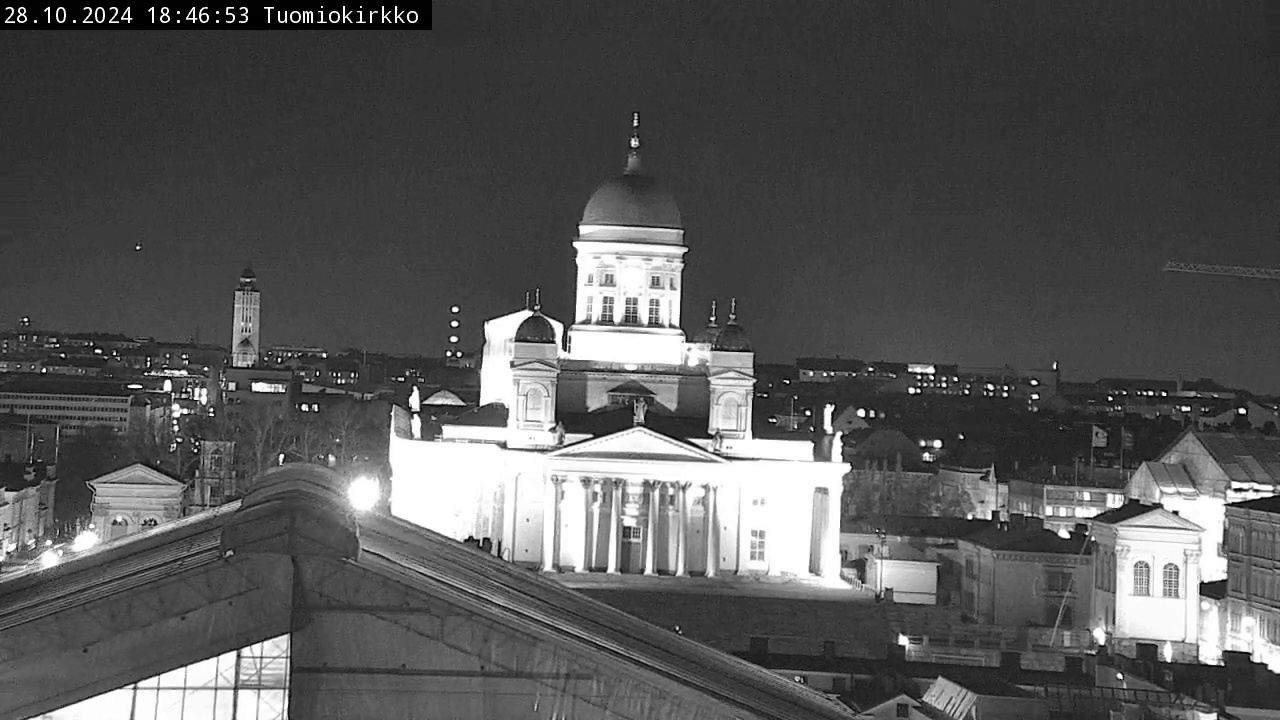

In [ ]:
#| skip
YouTubeLive().dump()

In [ ]:
#YouTubeLive().capture_frames()

In [ ]:
import glob

In [ ]:
files = glob.glob('../data/*.jpg')
len(files), files[0]

(788, '../data/frame_1728043212.jpg')

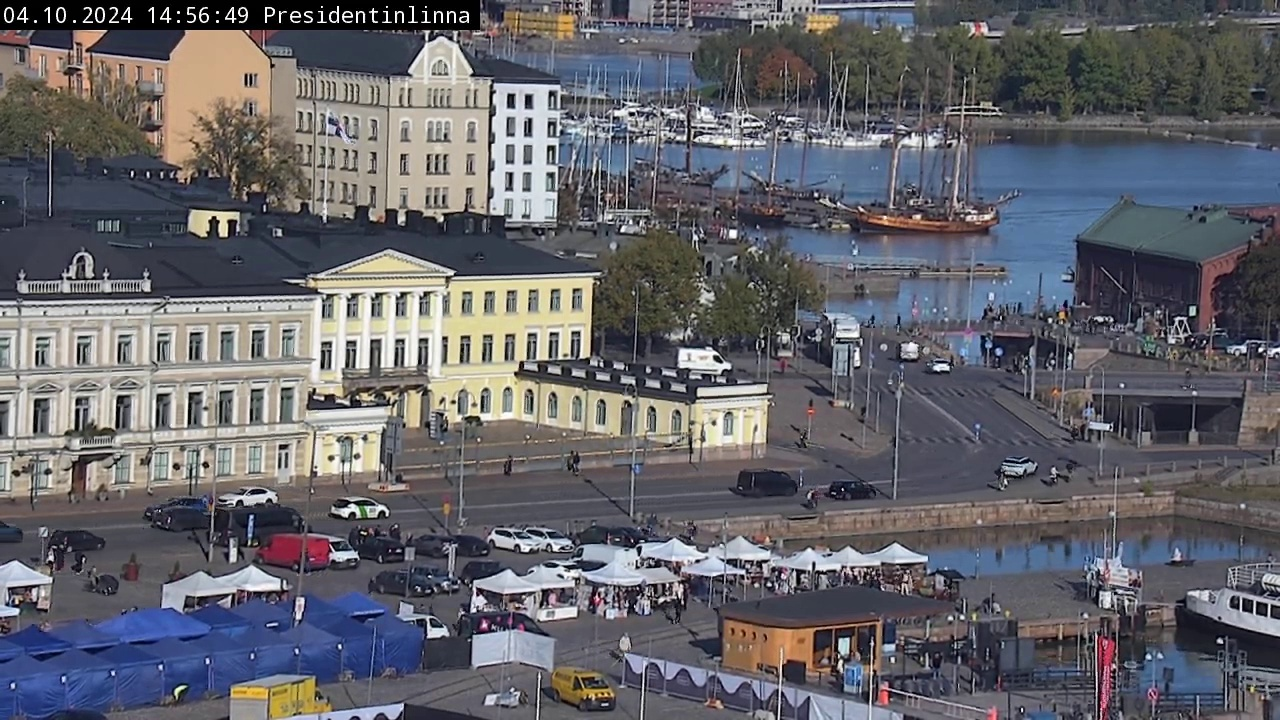

In [ ]:
from IPython.display import Image
Image(filename=files[1])

# Show image with specified rectangle

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

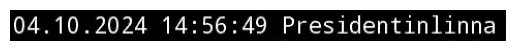

In [ ]:
image = Image.open(files[1])
rectangle_coords = (0, 0, 480, 30)
image = image.crop(rectangle_coords)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def crop(path, crop=(0, 0, 480, 30)): return Image.open(path).crop(crop)

In [ ]:
def show_image(path):
    plt.imshow(crop(path))
    plt.axis('off')
    plt.show()

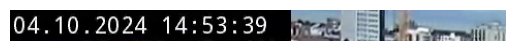

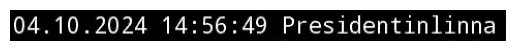

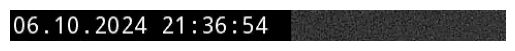

In [ ]:
for o in files[:3]:
    show_image(o)

# Extract meta data from an image file

In [ ]:
from pathlib import Path
from PIL import Image
import pytesseract
from datetime import datetime

In [ ]:
helsinki_known_places = [
    "Olympiaterminaali",
    "Etelasatama",
    "Presidentinlinna",
    "Tuomiokirkko",
    "Kauppatori",
    "Torni",
]

In [ ]:
def meta(path, known_places=helsinki_known_places):
    "Withdraw meta data, datetime & place"
    txt = pytesseract.image_to_string(crop(path)).strip()
    dt, pl = txt[:19], txt[20:] # Original format:"04.10.2024  14:53:49  Kauppatori"
    if pl not in known_places:
        raise Exception("No place specified")
    dt = datetime.strptime(dt,"%d.%m.%Y %H:%M:%S")
    return dt, pl

In [ ]:
def fname(prefix, dt, pl): return f"{prefix}{dt.strftime("%Y.%m.%d_%H:%M:%S")}_{pl}"

In [ ]:
#| skip
for i, o in enumerate(files[:30]):
    try:
        dt, pl = meta(o, known_places)
        print(i, fname("cap_", dt, pl))
    except:
        continue

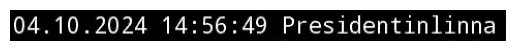

(None, '../data/frame_1728043403.jpg')

In [ ]:
show_image(files[1]), files[1]

In [ ]:
import os

In [ ]:
#os.rename("/tmp/a.txt", "/tmp/b.txt")

In [ ]:
#| skip
#fname("cap_", *meta(files[1]))

## Rename files with meta info

"cap_2024.10.04_14:56:49_Presidentinlinna"

"cap_2024.10.06_19:04:14_Kauppatori"

"cap_2024.10.06_20:08:29_Kauppatori"

In [ ]:
#| skip
for i, o in enumerate(files):
    if not os.path.exists(o):
        continue        
    try:
        new = Path("../data")/fname("cap_", *meta(o))
        print(i, o, " -> ", new)
        #os.rename(o, new)
    except Exception as e:
        continue

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()